In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import seaborn as sns

# Data Preprocessing

In [2]:
df = pd.read_csv('./archive/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


0    284315
1       492
Name: Class, dtype: int64
----------------------------------------------
0    99.827251
1     0.172749
Name: Class, dtype: float64


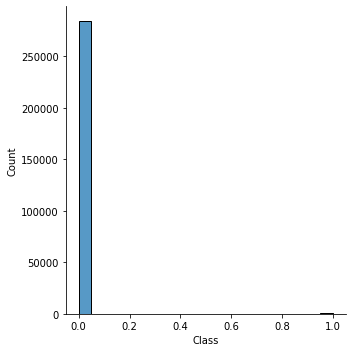

In [3]:
print(df['Class'].value_counts())
print('----------------------------------------------')
print(df['Class'].value_counts(normalize=True) * 100)
df = df.drop('Time', axis=1)
df_pos = df[df['Class'] == 0]
df_pos = df_pos.sample(frac=1)
df_neg = df[df['Class'] == 1]
df_neg = df_neg.sample(frac=1)
sns.displot(df['Class'])

## Data Inbalance

In [4]:
batch_size = 128
DATA_SPLIT_RATE = 0.8
train_point = int(len(df_pos) * DATA_SPLIT_RATE)

# Train set
train_set = df_pos[:train_point]
train_target = train_set['Class']
train_set = train_set.drop('Class', axis=1)
train_set.reset_index(drop=True, inplace=True)

# Validation set
val_set = df_pos[train_point:]
val_target = val_set['Class']
val_set = val_set.drop('Class', axis=1)
val_set.reset_index(drop=True, inplace=True)

In [5]:
# Train Loader
train = torch.tensor(train_set.values.astype(np.float32))
target = torch.tensor(train_target.values.astype(np.float32))
train_set = torch.utils.data.TensorDataset(train, target)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)

# Val Loader
val = torch.tensor(val_set.values.astype(np.float32))
target = torch.tensor(val_target.values.astype(np.float32))
val_set = torch.utils.data.TensorDataset(val, target)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Build Model

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(29, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 4),
            nn.ReLU()
        )
        self.Decoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 29),
        )
    def forward(self, inputs):
        codes = self.Encoder(inputs)
        decoded = self.Decoder(codes)
        return codes, decoded

## Optimizer and loss function

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)

LR = 5e-4
Epoch = 50
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# Training AutoEncoder

In [8]:
from tqdm import tqdm
for i in range(Epoch):
    train_loss = 0.0
    model.train()
    for idx, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        codes, decoded = model(inputs)
        
        loss = criterion(decoded, inputs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        # Show progress
        if idx % 1000 == 0:
            print('[{}/{}] Loss:'.format(i+1, Epoch), train_loss / 1000)
            train_loss = 0.0

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for idx, data in enumerate(val_loader):
            inputs = data[0].to(device)
            
            optimizer.zero_grad()
            codes, decoded = model(inputs)

            loss = criterion(decoded, inputs)

            val_loss += loss
            
            if idx % 200 == 0:
                print('Val Loss: {}'.format(val_loss / 200))
                val_loss = 0.0

# Save
torch.save(model, 'autoencoder.pth')

  2%|▏         | 41/1777 [00:00<00:17, 101.66it/s]

[1/50] Loss: 0.5000406188964843


 58%|█████▊    | 1036/1777 [00:05<00:03, 210.17it/s]

[1/50] Loss: 48.02493235856295


100%|██████████| 1777/1777 [00:09<00:00, 195.67it/s]


Val Loss: 0.006140353158116341
Val Loss: 0.703862190246582
Val Loss: 0.6990823745727539


  1%|          | 21/1777 [00:00<00:08, 202.47it/s]

[2/50] Loss: 0.0005767413973808288


 58%|█████▊    | 1032/1777 [00:04<00:03, 204.63it/s]

[2/50] Loss: 3.0321816562116144


100%|██████████| 1777/1777 [00:08<00:00, 205.51it/s]


Val Loss: 0.005405220668762922
Val Loss: 0.5470065474510193
Val Loss: 0.5555036664009094


  1%|          | 22/1777 [00:00<00:08, 217.23it/s]

[3/50] Loss: 0.0005079110264778138


 58%|█████▊    | 1038/1777 [00:05<00:03, 204.36it/s]

[3/50] Loss: 0.7237773318588734


100%|██████████| 1777/1777 [00:09<00:00, 180.81it/s]


Val Loss: 0.005916282534599304
Val Loss: 0.5268670320510864
Val Loss: 0.5381797552108765


  1%|          | 21/1777 [00:00<00:08, 206.44it/s]

[4/50] Loss: 0.0005031023621559143


 58%|█████▊    | 1022/1777 [00:06<00:06, 114.80it/s]

[4/50] Loss: 2.6742389395534993


100%|██████████| 1777/1777 [00:13<00:00, 133.33it/s]


Val Loss: 0.004878515377640724
Val Loss: 0.4855872690677643
Val Loss: 0.49457213282585144


  0%|          | 0/1777 [00:00<?, ?it/s]

[5/50] Loss: 0.0004725611507892609


 58%|█████▊    | 1027/1777 [00:06<00:03, 206.64it/s]

[5/50] Loss: 1.1153129563629627


100%|██████████| 1777/1777 [00:10<00:00, 169.62it/s]


Val Loss: 0.006793880369514227
Val Loss: 0.5433467626571655
Val Loss: 0.5562546849250793


  1%|          | 22/1777 [00:00<00:08, 210.05it/s]

[6/50] Loss: 0.0004975978434085846


 58%|█████▊    | 1039/1777 [00:05<00:03, 210.44it/s]

[6/50] Loss: 0.6198274760842323


100%|██████████| 1777/1777 [00:10<00:00, 163.16it/s]


Val Loss: 0.005433317273855209
Val Loss: 0.47713470458984375
Val Loss: 0.4827440679073334


  1%|          | 22/1777 [00:00<00:08, 215.17it/s]

[7/50] Loss: 0.0004643370509147644


 58%|█████▊    | 1024/1777 [00:06<00:03, 199.80it/s]

[7/50] Loss: 0.6682272102832795


100%|██████████| 1777/1777 [00:10<00:00, 170.55it/s]


Val Loss: 0.005247149150818586
Val Loss: 0.4760960340499878
Val Loss: 0.48493045568466187


  1%|          | 22/1777 [00:00<00:08, 218.34it/s]

[8/50] Loss: 0.00046177297830581667


 57%|█████▋    | 1019/1777 [00:07<00:03, 195.11it/s]

[8/50] Loss: 0.573023225069046


100%|██████████| 1777/1777 [00:10<00:00, 161.92it/s]


Val Loss: 0.0038744157645851374
Val Loss: 0.4540728032588959
Val Loss: 0.4570836126804352


  1%|          | 22/1777 [00:00<00:08, 210.08it/s]

[9/50] Loss: 0.0004404590129852295


 58%|█████▊    | 1031/1777 [00:06<00:04, 174.68it/s]

[9/50] Loss: 1.05483328589797


100%|██████████| 1777/1777 [00:10<00:00, 165.08it/s]


Val Loss: 0.005797840189188719
Val Loss: 0.47499826550483704
Val Loss: 0.483309268951416


  1%|          | 19/1777 [00:00<00:09, 184.97it/s]

[10/50] Loss: 0.00044817620515823366


 57%|█████▋    | 1011/1777 [00:07<00:07, 102.88it/s]

[10/50] Loss: 0.5887070261240005


100%|██████████| 1777/1777 [00:12<00:00, 140.42it/s]


Val Loss: 0.005556369666010141
Val Loss: 0.44607073068618774
Val Loss: 0.45179319381713867


  1%|          | 20/1777 [00:00<00:09, 194.70it/s]

[11/50] Loss: 0.0004255470931529999


 58%|█████▊    | 1036/1777 [00:05<00:03, 190.48it/s]

[11/50] Loss: 1.1105936580598355


100%|██████████| 1777/1777 [00:12<00:00, 145.23it/s]


Val Loss: 0.004116475582122803
Val Loss: 0.40575453639030457
Val Loss: 0.410312294960022


  1%|          | 14/1777 [00:00<00:25, 68.72it/s]

[12/50] Loss: 0.00042181411385536194


 57%|█████▋    | 1013/1777 [00:19<00:11, 68.65it/s]

[12/50] Loss: 0.5796192374825477


100%|██████████| 1777/1777 [00:29<00:00, 59.44it/s]


Val Loss: 0.005222670268267393
Val Loss: 0.4557517468929291
Val Loss: 0.4594822824001312


  0%|          | 8/1777 [00:00<00:24, 72.92it/s]

[13/50] Loss: 0.0004286819398403168


 58%|█████▊    | 1030/1777 [00:12<00:03, 202.04it/s]

[13/50] Loss: 1.3058596150279045


100%|██████████| 1777/1777 [00:15<00:00, 112.00it/s]


Val Loss: 0.004741203505545855
Val Loss: 0.4368790090084076
Val Loss: 0.44438356161117554


  1%|          | 22/1777 [00:00<00:08, 210.35it/s]

[14/50] Loss: 0.00042952123284339906


 58%|█████▊    | 1027/1777 [00:06<00:06, 120.90it/s]

[14/50] Loss: 0.596965803951025


100%|██████████| 1777/1777 [00:10<00:00, 169.84it/s]


Val Loss: 0.006137804128229618
Val Loss: 0.49760836362838745
Val Loss: 0.5107284784317017


  1%|          | 21/1777 [00:00<00:08, 200.93it/s]

[15/50] Loss: 0.0004755297601222992


 58%|█████▊    | 1031/1777 [00:04<00:03, 205.10it/s]

[15/50] Loss: 0.6696641369760037


100%|██████████| 1777/1777 [00:11<00:00, 153.79it/s]


Val Loss: 0.004378243815153837
Val Loss: 0.4626651704311371
Val Loss: 0.46221527457237244


  0%|          | 7/1777 [00:00<00:25, 69.49it/s]

[16/50] Loss: 0.00044064149260520936


 57%|█████▋    | 1008/1777 [00:13<00:10, 74.54it/s]

[16/50] Loss: 0.5808527618646622


100%|██████████| 1777/1777 [00:24<00:00, 73.33it/s]


Val Loss: 0.0032936283387243748
Val Loss: 0.411655992269516
Val Loss: 0.40793830156326294


  1%|          | 16/1777 [00:00<00:23, 73.41it/s]

[17/50] Loss: 0.0004018136262893677


 57%|█████▋    | 1009/1777 [00:16<00:13, 56.94it/s]

[17/50] Loss: 1.060768301486969


100%|██████████| 1777/1777 [00:23<00:00, 76.23it/s] 


Val Loss: 0.003922598902136087
Val Loss: 0.37832239270210266
Val Loss: 0.38351061940193176


  1%|          | 21/1777 [00:00<00:08, 204.43it/s]

[18/50] Loss: 0.0003945059180259705


 57%|█████▋    | 1012/1777 [00:05<00:07, 101.85it/s]

[18/50] Loss: 0.8163563187122345


100%|██████████| 1777/1777 [00:10<00:00, 174.53it/s]


Val Loss: 0.0036280634813010693
Val Loss: 0.3638439476490021
Val Loss: 0.368532657623291


  1%|          | 21/1777 [00:00<00:08, 202.35it/s]

[19/50] Loss: 0.00038404932618141176


 58%|█████▊    | 1025/1777 [00:04<00:03, 206.01it/s]

[19/50] Loss: 0.4624246788024902


100%|██████████| 1777/1777 [00:08<00:00, 207.24it/s]


Val Loss: 0.005328236613422632
Val Loss: 0.4096929728984833
Val Loss: 0.413007915019989


  1%|          | 20/1777 [00:00<00:09, 194.70it/s]

[20/50] Loss: 0.00041021621227264405


 57%|█████▋    | 1008/1777 [00:12<00:10, 74.86it/s]

[20/50] Loss: 0.6465682828426361


100%|██████████| 1777/1777 [00:22<00:00, 78.71it/s]


Val Loss: 0.0027233341243118048
Val Loss: 0.3557012975215912
Val Loss: 0.3602709174156189


  0%|          | 8/1777 [00:00<00:22, 78.64it/s]

[21/50] Loss: 0.0003852049708366394


 57%|█████▋    | 1010/1777 [00:14<00:10, 71.48it/s]

[21/50] Loss: 0.39183866800367834


100%|██████████| 1777/1777 [00:24<00:00, 72.03it/s]


Val Loss: 0.002439019037410617
Val Loss: 0.33215799927711487
Val Loss: 0.3329411745071411


  1%|          | 20/1777 [00:00<00:08, 196.60it/s]

[22/50] Loss: 0.0003841032683849335


 58%|█████▊    | 1024/1777 [00:04<00:03, 214.19it/s]

[22/50] Loss: 0.45604910393059256


100%|██████████| 1777/1777 [00:08<00:00, 206.80it/s]


Val Loss: 0.002995518734678626
Val Loss: 0.35193774104118347
Val Loss: 0.3517908751964569


  1%|          | 21/1777 [00:00<00:08, 202.60it/s]

[23/50] Loss: 0.00037552016973495483


 58%|█████▊    | 1025/1777 [00:05<00:03, 204.35it/s]

[23/50] Loss: 0.4084749242067337


100%|██████████| 1777/1777 [00:08<00:00, 199.26it/s]


Val Loss: 0.0025915568694472313
Val Loss: 0.33278772234916687
Val Loss: 0.33011943101882935


  1%|          | 19/1777 [00:00<00:09, 184.96it/s]

[24/50] Loss: 0.0003729458749294281


 58%|█████▊    | 1030/1777 [00:04<00:03, 211.48it/s]

[24/50] Loss: 0.43258466218411923


100%|██████████| 1777/1777 [00:11<00:00, 159.17it/s]


Val Loss: 0.00698079913854599
Val Loss: 0.45791110396385193
Val Loss: 0.47149375081062317


  0%|          | 8/1777 [00:00<00:24, 73.59it/s]

[25/50] Loss: 0.00042834565043449403


 57%|█████▋    | 1009/1777 [00:15<00:10, 72.80it/s]

[25/50] Loss: 0.5921873652935028


100%|██████████| 1777/1777 [00:28<00:00, 62.54it/s]


Val Loss: 0.0026280467864125967
Val Loss: 0.3487717807292938
Val Loss: 0.3499692976474762


  1%|          | 16/1777 [00:00<00:23, 75.46it/s]

[26/50] Loss: 0.0003574539422988892


 57%|█████▋    | 1019/1777 [00:15<00:06, 117.81it/s]

[26/50] Loss: 0.41921592834591864


100%|██████████| 1777/1777 [00:21<00:00, 83.55it/s] 


Val Loss: 0.00246018311008811
Val Loss: 0.3120713531970978
Val Loss: 0.3070307970046997


  1%|          | 22/1777 [00:00<00:08, 218.41it/s]

[27/50] Loss: 0.0003371855318546295


 59%|█████▊    | 1040/1777 [00:08<00:04, 175.71it/s]

[27/50] Loss: 1.6698436946123838


100%|██████████| 1777/1777 [00:12<00:00, 147.58it/s]


Val Loss: 0.002490764018148184
Val Loss: 0.3052056133747101
Val Loss: 0.30297642946243286


  1%|          | 21/1777 [00:00<00:08, 209.65it/s]

[28/50] Loss: 0.0003360576331615448


 57%|█████▋    | 1012/1777 [00:06<00:10, 76.48it/s]

[28/50] Loss: 0.4890708075016737


100%|██████████| 1777/1777 [00:16<00:00, 108.60it/s]


Val Loss: 0.0022920737974345684
Val Loss: 0.30922675132751465
Val Loss: 0.30514103174209595


  0%|          | 6/1777 [00:00<00:33, 52.77it/s]

[29/50] Loss: 0.00034272223711013795


 57%|█████▋    | 1008/1777 [00:14<00:10, 71.45it/s]

[29/50] Loss: 0.5872693426012993


100%|██████████| 1777/1777 [00:25<00:00, 68.74it/s]


Val Loss: 0.0025421755854040384
Val Loss: 0.3012670874595642
Val Loss: 0.3012066185474396


  0%|          | 8/1777 [00:00<00:24, 73.60it/s]

[30/50] Loss: 0.0003280574083328247


 57%|█████▋    | 1015/1777 [00:11<00:06, 115.41it/s]

[30/50] Loss: 0.380112883284688


100%|██████████| 1777/1777 [00:16<00:00, 109.67it/s]


Val Loss: 0.003446792019531131
Val Loss: 0.3148392140865326
Val Loss: 0.31492823362350464


  1%|          | 14/1777 [00:00<00:12, 137.62it/s]

[31/50] Loss: 0.0003322887718677521


 58%|█████▊    | 1039/1777 [00:05<00:03, 211.75it/s]

[31/50] Loss: 0.39272848328948023


100%|██████████| 1777/1777 [00:09<00:00, 178.09it/s]


Val Loss: 0.0030129309743642807
Val Loss: 0.314493864774704
Val Loss: 0.31146949529647827


  1%|          | 18/1777 [00:00<00:10, 173.49it/s]

[32/50] Loss: 0.0003374377191066742


 57%|█████▋    | 1015/1777 [00:06<00:10, 75.53it/s]

[32/50] Loss: 0.6431917870342732


100%|██████████| 1777/1777 [00:17<00:00, 100.47it/s]


Val Loss: 0.0021689857821911573
Val Loss: 0.2955366373062134
Val Loss: 0.2932540476322174


  1%|          | 17/1777 [00:00<00:21, 81.15it/s]

[33/50] Loss: 0.00033242058753967283


 57%|█████▋    | 1010/1777 [00:18<00:14, 53.42it/s]

[33/50] Loss: 0.4246333264857531


100%|██████████| 1777/1777 [00:31<00:00, 56.07it/s]


Val Loss: 0.0020846505649387836
Val Loss: 0.29076433181762695
Val Loss: 0.28759291768074036


  2%|▏         | 34/1777 [00:00<00:10, 168.72it/s]

[34/50] Loss: 0.00031976696848869324


 57%|█████▋    | 1017/1777 [00:06<00:04, 175.42it/s]

[34/50] Loss: 0.34427713124454024


100%|██████████| 1777/1777 [00:11<00:00, 155.45it/s]


Val Loss: 0.0022676517255604267
Val Loss: 0.2895701825618744
Val Loss: 0.2863360643386841


  1%|          | 13/1777 [00:00<00:14, 120.69it/s]

[35/50] Loss: 0.0003225155770778656


 58%|█████▊    | 1032/1777 [00:05<00:04, 180.88it/s]

[35/50] Loss: 0.37012197253108026


100%|██████████| 1777/1777 [00:09<00:00, 179.91it/s]


Val Loss: 0.002110369736328721
Val Loss: 0.28798753023147583
Val Loss: 0.2832653820514679


  1%|          | 19/1777 [00:00<00:09, 185.67it/s]

[36/50] Loss: 0.0003271312415599823


 57%|█████▋    | 1009/1777 [00:09<00:11, 64.19it/s]

[36/50] Loss: 0.5488090057224035


100%|██████████| 1777/1777 [00:24<00:00, 73.68it/s]


Val Loss: 0.0026961425319314003
Val Loss: 0.29562026262283325
Val Loss: 0.2938043475151062


  0%|          | 6/1777 [00:00<00:34, 52.08it/s]

[37/50] Loss: 0.0003066273331642151


 57%|█████▋    | 1010/1777 [00:21<00:16, 47.38it/s]

[37/50] Loss: 0.36508922338485716


100%|██████████| 1777/1777 [00:28<00:00, 62.40it/s] 


Val Loss: 0.0045606461353600025
Val Loss: 0.3627813756465912
Val Loss: 0.3635450303554535


  0%|          | 0/1777 [00:00<?, ?it/s]

[38/50] Loss: 0.00034590905904769895


 58%|█████▊    | 1036/1777 [00:06<00:04, 181.26it/s]

[38/50] Loss: 0.4145996844619513


100%|██████████| 1777/1777 [00:10<00:00, 166.35it/s]


Val Loss: 0.0051232073456048965
Val Loss: 0.385333776473999
Val Loss: 0.3901647627353668


  1%|          | 20/1777 [00:00<00:08, 198.55it/s]

[39/50] Loss: 0.00035098931193351744


 58%|█████▊    | 1032/1777 [00:05<00:03, 193.06it/s]

[39/50] Loss: 0.6832797048538923


100%|██████████| 1777/1777 [00:09<00:00, 188.30it/s]


Val Loss: 0.00410798005759716
Val Loss: 0.32248455286026
Val Loss: 0.32818910479545593


  0%|          | 7/1777 [00:00<00:27, 64.99it/s]

[40/50] Loss: 0.0003126424252986908


 57%|█████▋    | 1009/1777 [00:16<00:11, 64.80it/s]

[40/50] Loss: 0.35643401357531546


100%|██████████| 1777/1777 [00:29<00:00, 60.33it/s]


Val Loss: 0.0017976444214582443
Val Loss: 0.2717870771884918
Val Loss: 0.26608797907829285


  0%|          | 7/1777 [00:00<00:27, 64.59it/s]

[41/50] Loss: 0.00029141339659690855


 57%|█████▋    | 1011/1777 [00:16<00:12, 61.25it/s]

[41/50] Loss: 0.389294294655323


100%|██████████| 1777/1777 [00:21<00:00, 82.90it/s] 


Val Loss: 0.0019540779758244753
Val Loss: 0.2838767468929291
Val Loss: 0.2828191816806793


  1%|          | 17/1777 [00:00<00:10, 167.05it/s]

[42/50] Loss: 0.0003028123676776886


 58%|█████▊    | 1034/1777 [00:06<00:04, 178.44it/s]

[42/50] Loss: 0.37024142742156985


100%|██████████| 1777/1777 [00:09<00:00, 178.40it/s]


Val Loss: 0.001845502178184688
Val Loss: 0.26673442125320435
Val Loss: 0.26301270723342896


  1%|          | 21/1777 [00:00<00:08, 204.43it/s]

[43/50] Loss: 0.0002826594114303589


 57%|█████▋    | 1021/1777 [00:06<00:04, 152.64it/s]

[43/50] Loss: 0.5534590279012919


100%|██████████| 1777/1777 [00:12<00:00, 142.73it/s]


Val Loss: 0.0019640843383967876
Val Loss: 0.28818774223327637
Val Loss: 0.2863237261772156


  1%|          | 14/1777 [00:00<00:27, 63.56it/s]

[44/50] Loss: 0.00029336678981781004


 57%|█████▋    | 1013/1777 [00:15<00:10, 72.90it/s]

[44/50] Loss: 0.3957612347751856


100%|██████████| 1777/1777 [00:26<00:00, 67.42it/s]


Val Loss: 0.0035375000443309546
Val Loss: 0.3614961802959442
Val Loss: 0.3649822771549225


  1%|          | 15/1777 [00:00<00:25, 68.16it/s]

[45/50] Loss: 0.0003453369140625


 57%|█████▋    | 1011/1777 [00:14<00:10, 73.75it/s]

[45/50] Loss: 0.3982676930576563


100%|██████████| 1777/1777 [00:20<00:00, 88.40it/s] 


Val Loss: 0.0042216177098453045
Val Loss: 0.31012246012687683
Val Loss: 0.31198662519454956


  1%|          | 18/1777 [00:00<00:09, 176.94it/s]

[46/50] Loss: 0.0003066003620624542


 58%|█████▊    | 1036/1777 [00:05<00:04, 180.45it/s]

[46/50] Loss: 0.351314282938838


100%|██████████| 1777/1777 [00:09<00:00, 191.33it/s]


Val Loss: 0.0024523665197193623
Val Loss: 0.27240562438964844
Val Loss: 0.2681928277015686


  1%|          | 20/1777 [00:00<00:09, 190.98it/s]

[47/50] Loss: 0.0002831113338470459


 59%|█████▊    | 1040/1777 [00:05<00:03, 208.07it/s]

[47/50] Loss: 0.33917761290073395


100%|██████████| 1777/1777 [00:09<00:00, 192.20it/s]


Val Loss: 0.004900539293885231
Val Loss: 0.3413039445877075
Val Loss: 0.3440103828907013


  1%|          | 21/1777 [00:00<00:08, 204.43it/s]

[48/50] Loss: 0.00031690460443496704


 57%|█████▋    | 1011/1777 [00:12<00:11, 65.74it/s]

[48/50] Loss: 0.34885565653443334


100%|██████████| 1777/1777 [00:24<00:00, 71.96it/s]


Val Loss: 0.002596015576273203
Val Loss: 0.2871268093585968
Val Loss: 0.2862560451030731


  0%|          | 7/1777 [00:00<00:25, 69.11it/s]

[49/50] Loss: 0.0002942468822002411


 57%|█████▋    | 1009/1777 [00:17<00:11, 66.53it/s]

[49/50] Loss: 0.3265348520129919


100%|██████████| 1777/1777 [00:26<00:00, 66.93it/s] 


Val Loss: 0.00206739385612309
Val Loss: 0.2700437307357788
Val Loss: 0.26797983050346375


  1%|          | 22/1777 [00:00<00:08, 210.12it/s]

[50/50] Loss: 0.00028891733288764955


 57%|█████▋    | 1019/1777 [00:06<00:04, 163.54it/s]

[50/50] Loss: 0.36526497796177865


100%|██████████| 1777/1777 [00:10<00:00, 175.74it/s]


Val Loss: 0.003540417179465294
Val Loss: 0.336928129196167
Val Loss: 0.3383140563964844


# Testing AutoEncoder

In [9]:
test_set = df_neg
test_set.reset_index(drop=True, inplace=True)
test_ = test_set.drop('Class', axis=1)
test_ = torch.tensor(test_.values.astype(np.float32))
target = test_set['Class']
target = torch.tensor(target.values.astype(np.float32))

test = torch.utils.data.TensorDataset(test_, target)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [10]:
THRESHOLD = 2.0
model.eval()
test_acc = 0
total = len(df_neg)
with torch.no_grad():
    for idx, data in enumerate(test_loader):
        inputs = data[0].to(device)
        labels = data[1].to(device)

        codes, decoded = model(inputs)
        
        loss = criterion(inputs, decoded)

        if loss.item() >= THRESHOLD:
            test_acc += 1
    print('Testing Acc: %.2f %%'%(test_acc / total * 100))

Testing Acc: 0.81 %


# Using Classification

In [50]:
# Build Training Data
df_all = pd.concat([df_pos, df_neg], ignore_index=True)
df_all = df_all.sample(frac=1)
df_all.reset_index(drop=True, inplace=True)

SPLIT = int(len(df_all) * DATA_SPLIT_RATE)

train_set = df[:SPLIT]
train = train_set.drop('Class', axis=1)
train_target = train_set['Class']
train = torch.tensor(train.values.astype(np.float32)).to(device)
train_target = torch.LongTensor(train_target.values.astype(int))

train_ = torch.utils.data.TensorDataset(train, train_target)
train_loader = DataLoader(train_, batch_size=batch_size, shuffle=False)

test_set = df[SPLIT:]
test = test_set.drop('Class', axis=1)
test_target = test_set['Class']
test = torch.tensor(test.values.astype(np.float32)).to(device)
test_target = torch.tensor(test_target.values.astype(np.float32)).type(torch.LongTensor)

test_ = torch.utils.data.TensorDataset(test, test_target)
test_loader = DataLoader(test_, batch_size=batch_size, shuffle=False)

In [12]:
print('Train size: {}'.format(train.size()))

Train size: torch.Size([227845, 29])


In [54]:
# Appending AE data
codes_data = torch.empty((1, 4)).to(device)
decoded_data = torch.empty((1, 29)).to(device)
model.eval()
for data in tqdm(train_loader):
    inputs = data[0].to(device)
    
    codes, decodeds = model(inputs)
    loss = criterion(inputs, decodeds)

    for code in codes:
        codes_data = torch.cat((codes_data, torch.reshape(code, (1, 4))), 0)
    for decoded in decodeds:
        decoded_data = torch.cat((decoded_data, torch.reshape(decoded, (1, 29))), 0)
codes_data = codes_data[1:]
decoded_data = decoded_data[1:]

100%|██████████| 1781/1781 [03:02<00:00,  9.77it/s]


In [14]:
print('Code size: {}, Decoded size: {}'.format(codes_data.size(), decoded_data.size()))

Code size: torch.Size([227845, 4]), Decoded size: torch.Size([227845, 29])


In [60]:
target = train_target.long()
print(target.type())

torch.LongTensor


In [55]:
# Concat AE inputs, Embedding, outputs
train = torch.cat((train, codes_data, decoded_data), 1)
print(train.size())

torch.Size([227845, 62])


In [61]:
train_ = torch.utils.data.TensorDataset(train, target)
train_loader = DataLoader(train_, batch_size=batch_size, shuffle=False)

In [17]:
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.FC = nn.Sequential(
            nn.Linear(62, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 2),
        )
    def forward(self, x):
        x = self.FC(x)
        return x

In [76]:
Cmodel = Classification().to(device)
loss_function = nn.CrossEntropyLoss().to(device)
lr_ = 3e-4
optimizer = optim.AdamW(Cmodel.parameters(), lr= lr_)
Epoch = 20

In [ ]:
for epoch in range(Epoch):
    Cmodel.train()
    train_loss = 0.0
    train_acc = 0
    total = 0
    for idx, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = Cmodel(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.size(0)

        _, predict = torch.max(outputs, 1)
        train_acc += torch.sum(predict == labels.data)
        train_loss += loss.item()

        if idx % 1000 == 0:
            print('Epoch [%d/%d] : loss = %.3f'%(epoch+1, Epoch, (train_loss / 1000)))
            print('Training ACC: %.3f'%(train_acc / total))
            train_loss = 0.0
            train_acc = 0
            total = 0